In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import time
import scienceplots # better plots, requires latex installed
plt.style.use(['science','grid'])

### Simulate the stifness coefficients as lognormal random fields

In [3]:
def correlation_function(distance,i=2):
    """Exponential correlation function."""
    return np.exp(-distance**i)

def compute_correlation_matrix(grid,kernel, bx,by):
    """Compute the correlation matrix for a 2D grid."""
    N = grid.shape[0]
    C = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d = np.sqrt(((grid[i, 0] - grid[j, 0])/bx)**2 + ((grid[i, 1] - grid[j, 1])/by)**2)
            C[i, j] = kernel(d)
    return C


def KL_expansion(grid, kernel, C_param,truncation_order):
    """Compute the KL expansion."""
    N = grid.shape[0]
    mu = C_param[0]
    sigma = C_param[1]
    bx = C_param[2]
    by = C_param[3]
    C = compute_correlation_matrix(grid, kernel, bx, by)
    eig_values, eig_vectors = np.linalg.eigh(C)
    # Sort eigenvalues and eigenvectors
    idx = eig_values.argsort()[::-1]
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:, idx]

    return eig_values[:truncation_order], eig_vectors[:, :truncation_order]

C11param = [1.55, 0.129, 20.18, 16.6]   # = [ mu, sigma , bx, by] 
C33param = [0.316, 0.027, 20.86, 15.08]

# Parameters
N = 27
Lmax = 100

# Create 2D grid
x = np.linspace(0, Lmax, N)
y = np.linspace(0, Lmax, N)
X, Y = np.meshgrid(x, y)
grid = np.column_stack((X.ravel(), Y.ravel()))

truncation_order = N**2 # Keep all modes (= number of grid points)

# Spectral decomposition
eig_values_C11, eig_vectors_C11 = KL_expansion(grid, correlation_function, C11param, truncation_order)
eig_values_C33, eig_vectors_C33 = KL_expansion(grid, correlation_function, C33param, truncation_order)

#thresholding at 0 eigenvalues
eig_values_C11[eig_values_C11<0]=0
eig_values_C33[eig_values_C33<0]=0

def C_from_xi(xi, eig_values, eig_vectors, C_param):
    """Compute the Lognormal field from the KL expansion."""
    N = int(np.sqrt(eig_vectors.shape[0]))
    Nsim = xi.shape[0]
    XC = eig_vectors @ (np.sqrt(eig_values) * xi).T
    C = np.exp(C_param[0] + C_param[1] * XC)
    C = C.reshape((N, N, Nsim))
    return C

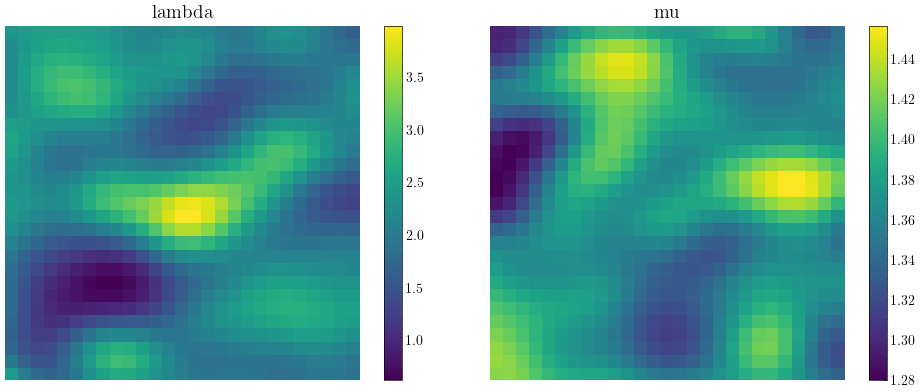

In [4]:
# Plotting function
def pcolor_plot(AX, X, Y, C, title,colormap="viridis",set_axis = 'off',**kwargs):
    ## plot the pcolor plot of the given data C on the given axis AX with the given title and optional colorbar limits cmin and cmax
    if len(kwargs) == 0:
        im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto')
    else:
        cmin = kwargs["cmin"]
        cmax = kwargs["cmax"]
        im = AX.pcolor(X, Y, C, cmap=colormap, vmin=cmin, vmax=cmax,shading='auto')
    AX.set_aspect("equal", "box")
    AX.axis(set_axis)
    AX.set_title(title, fontsize=14)
    return im


U_C11 = np.random.randn(10,N**2)
U_C33 = np.random.randn(10,N**2)

# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

# compute lambda and mu
lambda_ = C11 - 2*C33
mu = C33

# Plot first realization of lambda and mu fields
fig,ax = plt.subplots(1,2,figsize=(10,4))

imLambda = pcolor_plot(ax[0], X, Y, lambda_[:,:,0], "lambda")
fig.colorbar(imLambda, ax=ax[0])
imMu = pcolor_plot(ax[1], X, Y, mu[:,:,0], "mu")
fig.colorbar(imMu, ax=ax[1])
plt.tight_layout()

### FEM simulation using the generated fields

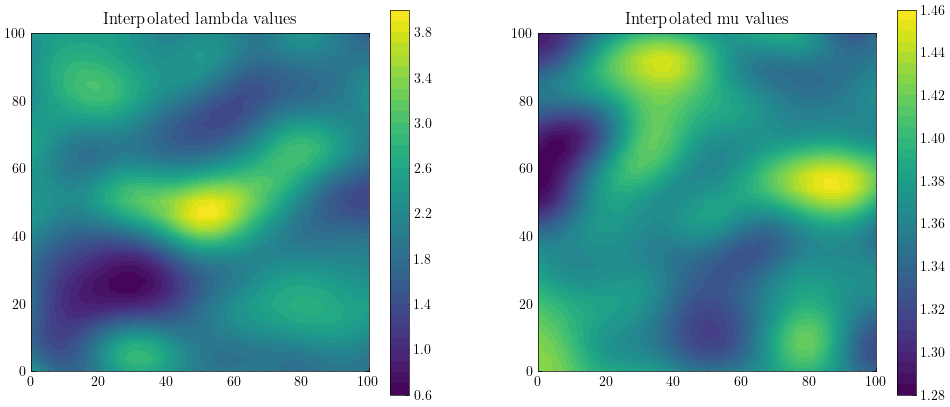

In [5]:
#Importing the fields to fenics
from fenics import *
from scipy.interpolate import griddata

Lmax = Constant(100)


# Create mesh and define function space
mesh = RectangleMesh(Point(0, 0), Point(Lmax, Lmax), 100, 100)
V_scalar = FunctionSpace(mesh, 'P', 1)  # Scalar function space

mesh_coordinates = V_scalar.tabulate_dof_coordinates().reshape((-1, 2))  # Adjust shape for 3D if necessary
interpolated_lambda_values = griddata(grid, lambda_[:,:,0].reshape(-1), mesh_coordinates, method='linear')
interpolated_mu_values = griddata(grid, mu[:,:,0].reshape(-1), mesh_coordinates, method='linear')

lambda_function = Function(V_scalar)
lambda_function.vector()[:] = interpolated_lambda_values
mu_function = Function(V_scalar)
mu_function.vector()[:] = interpolated_mu_values



# Plot interpolated values
fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
im = plot(lambda_function)
plt.colorbar(im)
plt.title('Interpolated lambda values')

fig.add_subplot(1, 2, 2)
im = plot(mu_function)
plt.colorbar(im)
plt.title('Interpolated mu values')
plt.show()

Solving linear variational problem.


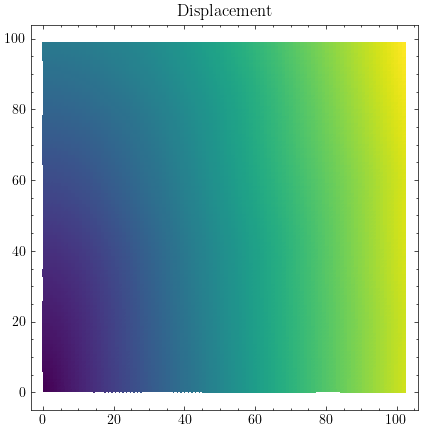

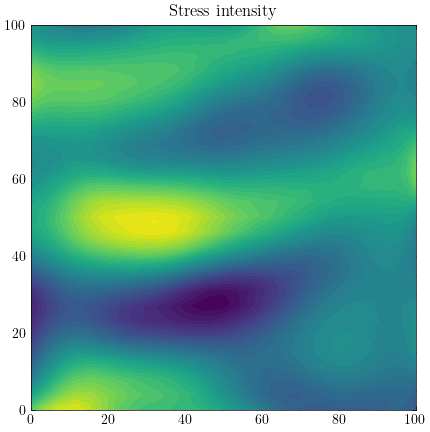

In [6]:
# Define boundary condition
pstress = 0.1

V = VectorFunctionSpace(mesh, 'P', 1)

tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lmax, tol)

bc1 = DirichletBC(V.sub(0), Constant(0), left_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2]

#mark right boundary
right = AutoSubDomain(right_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define strain and stress
def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_function*div(u)*Identity(d) + 2*mu_function*epsilon(u)

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
d = u.geometric_dimension()  # space dimension
v = TestFunction(V)
# f = (0, -x[0]/Lmax)
f = Constant((0, 0))

T = Constant((pstress, 0))
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds(1)

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution
plt.figure(figsize=(5, 5))
plot(u, title='Displacement', mode='displacement')
plt.axis('equal')

# Plot stress
stress = sigma(u) 
tensor_space = TensorFunctionSpace(mesh, 'P', 1)
stress = project(sigma(u), tensor_space)
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
plt.figure(figsize=(5, 5))
plot(von_Mises, title='Stress intensity')


# Compute magnitude of displacement
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, V)


# Save solution to file in VTK format
# File('elasticity/displacement.pvd') << u
# File('elasticity/von_mises.pvd') << von_Mises
# File('elasticity/magnitude.pvd') << u_magnitude

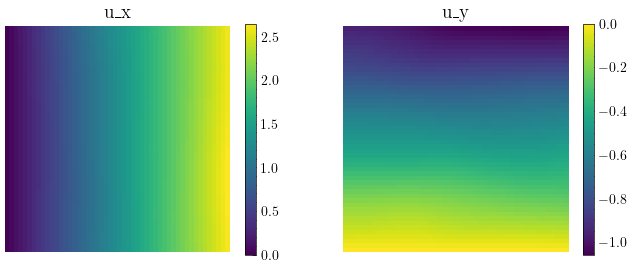

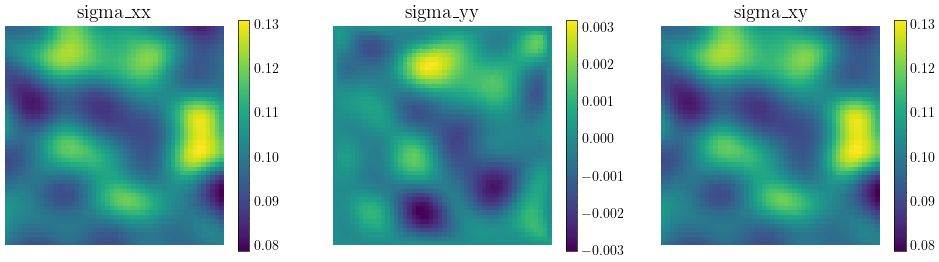

In [19]:
#Plot the solution in a regular grid (without fenics)
from scipy.interpolate import griddata

def create_regular_grid(coordinates, u_values, grid_res=50):
    # Create a regular grid
    x_min, y_min = np.min(coordinates, axis=0)
    x_max, y_max = np.max(coordinates, axis=0)
    grid_x, grid_y = np.mgrid[x_min:x_max:complex(grid_res), y_min:y_max:complex(grid_res)]

    # Interpolate unstructured data to the regular grid
    grid_u_values = griddata(coordinates, u_values, (grid_x, grid_y), method='cubic')
    
    return grid_x, grid_y, grid_u_values

# Extract vertex coordinates and displacement values
coordinates = mesh.coordinates()
u_values = u.compute_vertex_values(mesh)
s_xx = stress.sub(0, 0).compute_vertex_values(mesh)  # Sigma_xx
s_yy = stress.sub(1, 1).compute_vertex_values(mesh)  # Sigma_yy
s_xy = stress.sub(0, 1).compute_vertex_values(mesh)  # Sigma_xy

# Reshape displacement to have 2 components
u_values = u_values.reshape((2, -1))
for s in [s_xx, s_yy, s_xy]:
    s = s.reshape((1, -1))
# Interpolate data onto a regular grid
grid_x, grid_y, grid_u_x = create_regular_grid(coordinates, u_values[0, :])
_, _, grid_u_y = create_regular_grid(coordinates, u_values[1, :])
_, _, grid_s_xx = create_regular_grid(coordinates, s_xx)
_, _, grid_s_yy = create_regular_grid(coordinates, s_yy)
_, _, grid_s_xy = create_regular_grid(coordinates, s_xy)

# Plot displacement
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
im = pcolor_plot(ax[0], grid_x, grid_y, grid_u_x, "u_x")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], grid_x, grid_y, grid_u_y, "u_y")
fig.colorbar(im, ax=ax[1])

# Plot stress
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = pcolor_plot(ax[0], grid_x, grid_y, grid_s_xx, "sigma_xx")
fig.colorbar(im, ax=ax[0])
im = pcolor_plot(ax[1], grid_x, grid_y, grid_s_yy, "sigma_yy")
fig.colorbar(im, ax=ax[1])
im = pcolor_plot(ax[2], grid_x, grid_y, grid_s_xy, "sigma_xy")
fig.colorbar(im, ax=ax[2])


plt.show()


## Monte-Carlo

In [11]:
#Compute the solution for multiple realizations

from tqdm import tqdm

N_sim = int(1e2)
set_log_level(LogLevel.ERROR)  # Limit the verbosity of FEniCS

C11param = [ 1.55, 0.129, 50, 50]   # = [ mu, sigma , bx, by] 
C33param = [ 0.316, 0.027, 50, 50]

U_C11 = np.random.randn(N_sim,truncation_order)
U_C33 = np.random.randn(N_sim,truncation_order)

# Compute random coefficients
C11 = C_from_xi(U_C11, eig_values_C11, eig_vectors_C11, C11param)
C33 = C_from_xi(U_C33, eig_values_C33, eig_vectors_C33, C33param)

# compute lambda and mu
lambda_ = C11 - 2*C33
mu = C33

Lmax = Constant(100)

# Create mesh and define function space
mesh = RectangleMesh(Point(0, 0), Point(Lmax, Lmax), 100, 100)
V_scalar = FunctionSpace(mesh, 'P', 1)  # Scalar function space
V = VectorFunctionSpace(mesh, 'P', 1)


mesh_coordinates = V_scalar.tabulate_dof_coordinates().reshape((-1, 2))  # Adjust shape for 3D if necessary


lambda_function = Function(V_scalar)
mu_function = Function(V_scalar)

pstress = 0.1
tol = 1E-14

def left_boundary(x, on_boundary):
    return on_boundary and near(x[0], 0, tol)

def bottom_boundary(x, on_boundary):
    return on_boundary and near(x[1], 0, tol)

def right_boundary(x, on_boundary):
    return on_boundary and near(x[0], Lmax, tol)

bc1 = DirichletBC(V.sub(0), Constant(0), left_boundary)
bc2 = DirichletBC(V.sub(1), Constant(0), bottom_boundary)
bc = [bc1, bc2]

#mark right boundary
right = AutoSubDomain(right_boundary)
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)
right.mark(boundaries, 1)
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)


# Define strain and stress

def epsilon(u):
    return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    #return sym(nabla_grad(u))

# Define variational problem
x = SpatialCoordinate(mesh)
u = TrialFunction(V)
v = TestFunction(V)
f = Constant((0, 0))
T = Constant((pstress, 0))
L = dot(f, v)*dx + dot(T, v)*ds(1)

u_sol = []
lambda_functions = []

for i in tqdm(range(N_sim)):
    interpolated_lambda_values = griddata(grid, lambda_[:,:,i].reshape(-1), mesh_coordinates, method='linear')
    interpolated_mu_values = griddata(grid, mu[:,:,i].reshape(-1), mesh_coordinates, method='linear')
    lambda_function = Function(V_scalar)
    mu_function = Function(V_scalar)
    lambda_function.vector()[:] = interpolated_lambda_values
    mu_function.vector()[:] = interpolated_mu_values
    sigma = lambda u: lambda_function*div(u)*Identity(d) + 2*mu_function*epsilon(u)

    u = TrialFunction(V)
    a = inner(sigma(u), epsilon(v))*dx

    # Compute solution
    u = Function(V)
    solve(a == L, u, bc)
    u_sol.append(u)
    lambda_functions.append(lambda_function)

u = u_sol[0]
# plt.figure(figsize=(5, 5))
# plot(u, title='Displacement', mode='displacement')

# Plot stress
stress = sigma(u) 
tensor_space = TensorFunctionSpace(mesh, 'P', 1)
stress = project(sigma(u), tensor_space)
s = sigma(u) - (1./3)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = sqrt(3./2*inner(s, s))
V = FunctionSpace(mesh, 'P', 1)
von_Mises = project(von_Mises, V)
# plt.figure(figsize=(5, 5))
# plot(von_Mises, title='Stress intensity')

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


In [12]:
# Compute displacement mean and standard deviation 
u = np.stack([u.compute_vertex_values(mesh) for u in u_sol])

#save the reference solution
save = False
if save:
    np.save(f"MonteCarlo_u_1e{int(np.log10(N_sim))}.npy",u)

# MC_u = np.load(f"MonteCarlo_u_1e4.npy")
MC_u = u
u_mean = np.mean(MC_u,axis=0).reshape((2, -1))
u_std = np.std(MC_u,axis=0).reshape((2, -1))

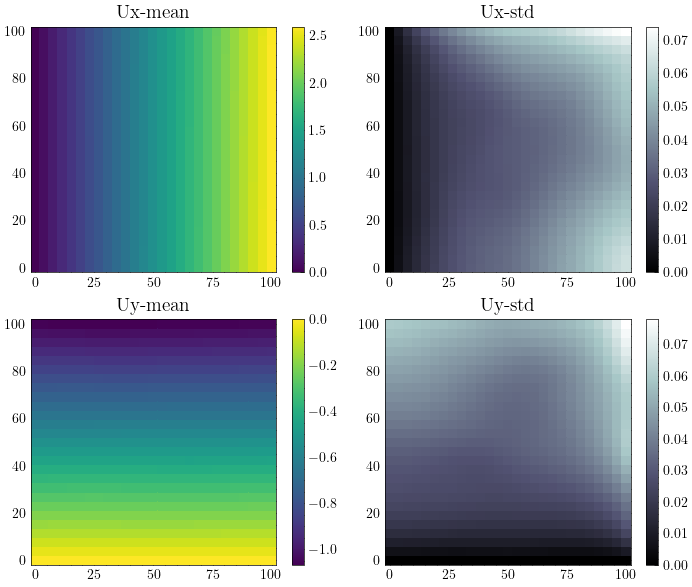

In [18]:
# Plot displacement
coordinates = mesh.coordinates()
grid_x, grid_y, u_mean_x = create_regular_grid(coordinates, u_mean[0, :],grid_res=27)
_, _, u_mean_y = create_regular_grid(coordinates, u_mean[1, :],grid_res=27)
_, _, u_std_x = create_regular_grid(coordinates, u_std[0, :],grid_res=27)
_, _, u_std_y = create_regular_grid(coordinates, u_std[1, :],grid_res=27)

fig, ax = plt.subplots(2, 2, figsize=(7.2, 6))
im = pcolor_plot(ax[0][0], grid_x, grid_y, u_mean_x, "Ux-mean",set_axis = 'on')
fig.colorbar(im, ax=ax[0][0])
im = pcolor_plot(ax[1][0], grid_x, grid_y, u_mean_y, "Uy-mean",set_axis = 'on')
fig.colorbar(im, ax=ax[1][0])
# plt.suptitle("Mean")

im = pcolor_plot(ax[0][1], grid_x, grid_y, u_std_x, "Ux-std",colormap="bone",set_axis = 'on')
fig.colorbar(im, ax=ax[0][1])
im = pcolor_plot(ax[1][1], grid_x, grid_y, u_std_y, "Uy-std",colormap="bone",set_axis = 'on')
fig.colorbar(im, ax=ax[1][1])
plt.tight_layout()
# fig.savefig('figures/MonteCarlo_u.pdf', dpi=300)